In [70]:
import numpy as np
import numpy.random as rando
import math
import pandas as pd
import os
import scipy.integrate
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats


In [71]:
def read_file(file_name):
    file_path = os.path.join(file_name)
    print(file_path)
    print(os.getcwd())
    df = pd.read_csv(file_name,delimiter=",",names=["accX","accY","accZ","gyroX","gyroY","gyroZ","alt","temp"],header=None)
    return df
df = read_file("fast.txt")
data = df[["accX","accY","accZ","gyroX","gyroY","gyroZ"]]

fast.txt
/home/theurerjohn3


In [72]:
# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def rotationMatrixToEulerAngles(R) :
 
     
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
     
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])

In [73]:
def gyrotoeuler(gyro,pos,dt):
    sinPhi = math.sin(pos[0])
    cosPhi = math.cos(pos[0])
    cosTheta = math.cos(pos[1])
    tanTheta = math.tan(pos[1])
    
    cat = []
    
    cat.append(pos[0]+dt*(gyro[0]+gyro[1]*sinPhi*tanTheta+gyro[2]*cosPhi*tanTheta))
    cat.append(pos[1]+dt*(gyro[1]*cosPhi-gyro[2]*sinPhi))
    cat.append(pos[1]*sinPhi/cosTheta+pos[2]*cosPhi/cosTheta)
    
    return np.matrix(cat)
    

In [74]:
cum_rot = np.matrix(
[[ 0.97606517,  0.21709993, -0.01282223],
 [-0.21709993,  0.96919611, -0.11630353],
 [-0.01282223,  0.11630353,  0.99313095]]
)
cum_vel = np.matrix([
    [0],
    [0],
    [0]
])
cum_pos = np.matrix([
    [0],
    [0],
    [0]
])
inital_rot = np.matrix([
       [ 0.98,  0.22, -0.01],
       [-0.22,  0.97, -0.12],
       [-0.01,  0.12,  0.99]
])
print(rotationMatrixToEulerAngles(inital_rot))
g_rot=(np.matrix([[0],[0],[-9.8]]).T*inital_rot)
print(g_rot)
delta_t = 0.1
x_acc_coll = []
y_acc_coll = []
z_acc_coll = []
det_collection = []
tot_acc_coll = []
samp = 1600
start = 0
firsty =[]
for k in range(start,samp):
    g_norm = [[data.loc[k]["accX"]],[data.loc[k]["accY"]],[data.loc[k]["accZ"]]]
    print(g_norm)
    for i in range(0,3):
        g_norm[i]= g_norm[i][0]
        
    g_norm = np.matrix(g_norm)
    
    holder = [data.loc[k]["gyroX"],data.loc[k]["gyroY"],data.loc[k]["gyroZ"]]
    
    for i in range(0,3):
        holder[i]= holder[i]
        
    holder = gyrotoeuler(holder,rotationMatrixToEulerAngles(cum_rot),delta_t).T
    z_rot = np.matrix([
        [ math.cos(math.radians(holder.item(2))) , -math.sin(math.radians(holder.item(2))) ,  0 ],
        [ math.sin(math.radians(holder.item(2))) , math.cos(math.radians(holder.item(2)))  , 0 ],
        [ 0 , 0 , 1 ]
    ])
    y_rot = np.matrix([
        [ math.cos(math.radians(holder.item(1)))  , 0 , math.sin(math.radians(holder.item(1))) ],
        [ 0 , 1 , 0 ],
        [ -math.sin(math.radians(holder.item(1))) ,  0 , math.cos(math.radians(holder.item(1))) ]
    ])
    x_rot = np.matrix([
        [ 1 , 0 , 0 ],
        [ 0 , math.cos(math.radians(holder.item(0))) , -math.sin(math.radians(holder.item(0))) ],
        [ 0 , math.sin(math.radians(holder.item(0))) , math.cos(math.radians(holder.item(0))) ]
        
    ])
    total_rot = z_rot*y_rot*x_rot
    print("total rotation")
    print(total_rot)
    cum_rot = cum_rot *total_rot
    firsty.append(cum_rot.item(0,0))
    print("cum_rot")
    print(cum_rot)
    inertal_acc = cum_rot*g_norm.T
    inertal_acc = inertal_acc + g_rot.T
    #for i in range(0,3):
    #    if abs(inertal_acc[i])<2:
    #        inertal_acc[i]=0
    x_acc_coll.append(inertal_acc[0])
    y_acc_coll.append(inertal_acc[1])
    z_acc_coll.append(inertal_acc[2])
    tot_acc_coll.append(math.sqrt(inertal_acc[0]*inertal_acc[0]+inertal_acc[1]*inertal_acc[1]+inertal_acc[2]*inertal_acc[2]))
    vel = inertal_acc*delta_t
    cum_vel = cum_vel+vel
    print("cum_Vel")
    print(cum_vel)
    cum_pos = cum_pos + cum_vel*delta_t
    print("position")
    print(cum_pos)
    det_collection.append(np.linalg.det(cum_rot))
    

[ 0.12062367  0.00995596 -0.22082877]
[[ 0.098 -1.176 -9.702]]
[[0.0], [0.78000000000000003], [9.5299999999999994]]
total rotation
[[  9.99982872e-01   3.76724266e-03   4.47916698e-03]
 [ -3.76814809e-03   9.99992882e-01   1.93721415e-04]
 [ -4.47840530e-03  -2.10596262e-04   9.99989950e-01]]
cum_rot
[[ 0.97528781  0.22077816 -0.00840809]
 [-0.22022743  0.96839584 -0.11708703]
 [-0.0177079   0.11604525  0.99308607]]
cum_Vel
[[ 0.01900779]
 [-0.15364907]
 [-0.01473745]]
position
[[ 0.00190078]
 [-0.01536491]
 [-0.00147374]]
[[0.0], [0.75], [9.5700000000000003]]
total rotation
[[  9.99992682e-01   3.81519037e-03   2.83928187e-04]
 [ -3.81460082e-03   9.99990626e-01  -2.04877895e-03]
 [ -2.91742007e-04   2.04768088e-03   9.99997861e-01]]
cum_rot
[[ 0.97444095  0.22447978 -0.00858348]
 [-0.2238857   0.96730679 -0.11913334]
 [-0.01844016  0.11801012  0.99284116]]
cum_Vel
[[ 0.03742938]
 [-0.31271167]
 [-0.0259377 ]]
position
[[ 0.00564372]
 [-0.04663607]
 [-0.00406751]]
[[0.0400000000000000

cum_rot
[[ 0.87227785  0.48844204 -0.02357398]
 [-0.47469397  0.83417648 -0.28074049]
 [-0.11746059  0.25607414  0.95949416]]
cum_Vel
[[  1.13261697]
 [-11.8589738 ]
 [ -1.23725618]]
position
[[  2.90547926]
 [-27.60894107]
 [ -2.78787257]]
[[0.040000000000000001], [0.75], [9.4900000000000002]]
total rotation
[[ 0.99996648  0.00793841  0.00200616]
 [-0.00792915  0.99995806 -0.00458288]
 [-0.00204245  0.00456682  0.99998749]]
cum_rot
[[ 0.86842383  0.49523839 -0.02406223]
 [-0.48071896  0.8290911  -0.28551221]
 [-0.12144683  0.25951278  0.95807296]]
cum_Vel
[[  1.16019849]
 [-12.18726594]
 [ -1.27926727]]
position
[[  3.02149911]
 [-28.82766767]
 [ -2.9157993 ]]
[[0.0], [0.75], [9.4900000000000002]]
total rotation
[[ 0.99996561  0.00803032  0.00207079]
 [-0.00802062  0.99995702 -0.00465042]
 [-0.00210804  0.00463365  0.99998704]]
cum_rot
[[ 0.86447258  0.50207933 -0.02456666]
 [-0.48675038  0.82387217 -0.2903596 ]
 [-0.12554376  0.26296575  0.95660221]]
cum_Vel
[[  1.18434067]
 [-12.518

 [ -4.44617563]]
position
[[   9.31343121]
 [-108.20220285]
 [ -12.96932317]]
[[0.0], [0.75], [9.5299999999999994]]
total rotation
[[ 0.99991691  0.01093326  0.00682921]
 [-0.01088179  0.99991244 -0.00753016]
 [-0.00691094  0.00745522  0.99994833]]
cum_rot
[[ 0.6271137   0.77670696 -0.05877676]
 [-0.6707065   0.50007496 -0.54779359]
 [-0.39608231  0.38295082  0.83454627]]
cum_Vel
[[  1.98032792]
 [-30.41682483]
 [ -4.59233172]]
position
[[   9.511464  ]
 [-111.24388533]
 [ -13.42855634]]
[[0.0], [0.75], [9.5700000000000003]]
total rotation
[[ 0.99991523  0.01097288  0.00700909]
 [-0.01091957  0.9999115  -0.00759978]
 [-0.00709187  0.0075226   0.99994656]]
cum_rot
[[ 0.61899607  0.78307732 -0.06028092]
 [-0.67222537  0.48855028 -0.55626582]
 [-0.40614888  0.38484872  0.82881515]]
cum_Vel
[[  1.99116987]
 [-31.03012994]
 [ -4.74049197]]
position
[[   9.71058099]
 [-114.34689833]
 [ -13.90260554]]
[[0.0], [0.75], [9.5700000000000003]]
total rotation
[[ 0.99991342  0.01101005  0.00720701]


[[  15.31385557]
 [-406.97550208]
 [ -90.71217239]]
[[0.0], [0.78000000000000003], [9.5700000000000003]]
total rotation
[[ 0.99970375 -0.01961142  0.01441534]
 [ 0.02000657  0.9994133  -0.02779905]
 [-0.0138617   0.02807921  0.99950959]]
cum_rot
[[ 0.68681649  0.64495705 -0.3351321 ]
 [-0.20269474 -0.27283409 -0.94046605]
 [-0.69799567  0.71385711 -0.05665755]]
cum_Vel
[[ -2.42457552]
 [-79.80900349]
 [-30.86581377]]
position
[[  15.07139801]
 [-414.95640243]
 [ -93.79875377]]
[[0.0], [0.75], [9.5700000000000003]]
total rotation
[[ 0.99972237 -0.01892708  0.01403359]
 [ 0.01932157  0.99940622 -0.02852857]
 [-0.01348529  0.0287918   0.99949446]]
cum_rot
[[ 0.70360674  0.6219256  -0.34372388]
 [-0.19522759 -0.29591338 -0.93505158]
 [-0.68324501  0.72501298 -0.08678961]]
cum_Vel
[[ -2.69707485]
 [-80.84364135]
 [-31.86469546]]
position
[[  14.80169053]
 [-423.04076656]
 [ -96.98522331]]
[[0.0], [0.75], [9.5700000000000003]]
total rotation
[[ 0.99974022 -0.01822396  0.01368852]
 [ 0.018618

[[ -21.05612677]
 [-108.369243  ]
 [-132.05826573]]
position
[[  -62.50541695]
 [-1026.14999721]
 [ -567.68737199]]
[[0.040000000000000001], [0.70999999999999996], [9.4499999999999993]]
total rotation
[[ 0.99997318 -0.006218    0.00386902]
 [ 0.00641744  0.99852721 -0.05387233]
 [-0.00352835  0.05389571  0.99854034]]
cum_rot
[[  9.18982464e-01  -3.48806581e-01  -1.83861918e-01]
 [ -3.42154828e-01  -9.37194534e-01   6.77972734e-02]
 [ -1.95962518e-01   6.04737642e-04  -9.80611202e-01]]
cum_Vel
[[ -21.24116562]
 [-108.49068401]
 [-133.95588423]]
position
[[  -64.62953351]
 [-1036.99906561]
 [ -581.08296041]]
[[0.0], [0.70999999999999996], [9.4900000000000002]]
total rotation
[[ 0.99997388 -0.0061466   0.00380249]
 [ 0.00634575  0.99847769 -0.0547908 ]
 [-0.00345993  0.0548135   0.99849062]]
cum_rot
[[ 0.91738117 -0.36400232 -0.16097859]
 [-0.34832767 -0.92994854  0.11774354]
 [-0.19256072 -0.05194241 -0.97990936]]
cum_Vel
[[ -21.40997847]
 [-108.56257174]
 [-135.85970613]]
position
[[  -

 [-1541.07401164]]
[[0.0], [0.70999999999999996], [9.4499999999999993]]
total rotation
[[  9.99878994e-01  -1.55469282e-02   5.39070877e-04]
 [  1.54952093e-02   9.98423410e-01   5.39499079e-02]
 [ -1.37697633e-03  -5.39350266e-02   9.98543498e-01]]
cum_rot
[[ 0.61536494 -0.78648315 -0.05263325]
 [-0.78445366 -0.61757935  0.05681716]
 [-0.07719095  0.00632506 -0.99699627]]
cum_Vel
[[ -28.16142916]
 [-114.32805543]
 [-235.40373704]]
position
[[ -197.88053999]
 [-1627.41696034]
 [-1564.61438534]]
[[0.0], [0.67000000000000004], [9.4900000000000002]]
total rotation
[[ 0.99987328 -0.01576227  0.00223169]
 [ 0.01586074  0.99837777 -0.05468336]
 [-0.00136614  0.05471182  0.99850125]]
cum_rot
[[ 0.60288465 -0.7977865  -0.00817352]
 [-0.79422714 -0.60110415  0.08875266]
 [-0.07571881 -0.04701599 -0.99602016]]
cum_Vel
[[ -28.21283753]
 [-114.40170313]
 [-237.32231024]]
position
[[ -200.70182375]
 [-1638.85713065]
 [-1588.34661637]]
[[0.0], [0.67000000000000004], [9.4499999999999993]]
total rotat

[[  9.98682248e-01  -5.12690304e-02  -2.29231605e-03]
 [  5.13178255e-02   9.97204052e-01   5.43190550e-02]
 [ -4.98978431e-04  -5.43651126e-02   9.98520999e-01]]
cum_rot
[[-0.98863525 -0.1485165   0.02330649]
 [-0.14764384  0.98840213  0.03553192]
 [-0.02831327  0.03168705 -0.99909674]]
cum_Vel
[[ -31.49544486]
 [-119.2354209 ]
 [-367.83458556]]
position
[[ -408.09770568]
 [-2435.79810737]
 [-3652.20594653]]
[[0.0], [0.70999999999999996], [9.7300000000000004]]
total rotation
[[  9.98634933e-01  -5.21256500e-02   3.34468372e-03]
 [  5.22303407e-02   9.97164902e-01  -5.41677841e-02]
 [ -5.11670264e-04   5.42685354e-02   9.98526246e-01]]
cum_rot
[[-0.99505469 -0.09529738  0.02801028]
 [-0.09583589  0.99522421 -0.01855382]
 [-0.02610838 -0.02114646 -0.99943543]]
cum_Vel
[[ -31.46515697]
 [-119.30041284]
 [-369.77873764]]
position
[[ -411.24422137]
 [-2447.72814865]
 [-3689.1838203 ]]
[[0.0], [0.75], [9.4900000000000002]]
total rotation
[[  9.98587657e-01  -5.30738743e-02  -2.41956969e-03]

 [  8.82930926e-03  -4.64855571e-03  -9.99950218e-01]]
cum_Vel
[[ -31.33988807]
 [-121.61129215]
 [-511.87368547]]
position
[[ -642.59795382]
 [-3339.77283362]
 [-6958.39544357]]
[[0.0], [0.78000000000000003], [9.5299999999999994]]
total rotation
[[  9.98497107e-01   5.47296752e-02   2.86176791e-03]
 [ -5.48042732e-02   9.97001497e-01   5.46306447e-02]
 [  1.36730551e-04  -5.47053778e-02   9.98502530e-01]]
cum_rot
[[-0.99845783 -0.05427295 -0.01167927]
 [-0.05479179  0.99724571  0.04998843]
 [ 0.00893408  0.05055126 -0.99868151]]
cum_Vel
[[ -31.3454517 ]
 [-121.60346801]
 [-513.79168595]]
position
[[ -645.73249899]
 [-3351.93318043]
 [-7009.77461216]]
[[0.0], [0.67000000000000004], [9.5299999999999994]]
total rotation
[[  9.98553136e-01  -5.37028791e-02   2.76331341e-03]
 [  5.37737499e-02   9.97099055e-01  -5.38689000e-02]
 [  1.37617831e-04   5.39395528e-02   9.98544193e-01]]
cum_rot
[[-0.99993327 -0.00112542 -0.01149769]
 [-0.00108     0.99999159 -0.00395628]
 [ 0.01150204 -0.003943

[[  9.98552509e-01   5.36967271e-02  -3.08987211e-03]
 [ -5.37852099e-02   9.97102481e-01  -5.37939931e-02]
 [  1.92357785e-04   5.38823162e-02   9.98547274e-01]]
cum_rot
[[ -9.99959162e-01   1.11830218e-03  -8.96820536e-03]
 [  1.11361174e-03   9.99999236e-01   5.28186849e-04]
 [  8.96878656e-03   5.18177039e-04  -9.99959648e-01]]
cum_Vel
[[ -31.01883452]
 [-125.58906861]
 [-700.20489347]]
position
[[  -947.72455223]
 [ -4550.13625757]
 [-12907.0583495 ]]
[[0.0], [0.75], [9.5299999999999994]]
total rotation
[[  9.98498080e-01   5.46965591e-02  -3.14162879e-03]
 [ -5.47865318e-02   9.96997455e-01  -5.47221304e-02]
 [  1.39083663e-04   5.48120611e-02   9.98496679e-01]]
cum_rot
[[-0.99851982 -0.05407095 -0.00587442]
 [-0.05367448  0.99708655 -0.05419819]
 [ 0.00878785 -0.05380267 -0.99851292]]
cum_Vel
[[ -31.01868816]
 [-125.683538  ]
 [-702.13071149]]
position
[[  -950.82642104]
 [ -4562.70461138]
 [-12977.27142064]]
[[0.0], [0.75], [9.4900000000000002]]
total rotation
[[  9.98551715e-0

[[-0.99853124  0.05318528 -0.01032966]
 [ 0.05367101  0.99707217 -0.05446556]
 [ 0.00740265 -0.05493997 -0.99846222]]
cum_Vel
[[ -30.87849553]
 [-130.25643705]
 [-901.829902  ]]
position
[[ -1273.45174067]
 [ -5893.57305426]
 [-21327.88215418]]
[[0.040000000000000001], [0.70999999999999996], [9.5299999999999994]]
total rotation
[[  9.98552752e-01   5.37090251e-02   2.78253420e-03]
 [ -5.37809369e-02   9.97104731e-01   5.37565486e-02]
 [  1.12733800e-04  -5.38283968e-02   9.98550195e-01]]
cum_rot
[[ -9.99947632e-01  -4.28148532e-05  -1.02340779e-02]
 [ -3.62845939e-05   9.99999791e-01  -6.38095279e-04]
 [  1.02341005e-02  -6.37691674e-04  -9.99947429e-01]]
cum_Vel
[[ -30.88245144]
 [-130.30364532]
 [-903.75305624]]
position
[[ -1276.53998581]
 [ -5906.60341879]
 [-21418.25745981]]
[[0.0], [0.78000000000000003], [9.3000000000000007]]
total rotation
[[  9.98497009e-01  -5.47149626e-02  -3.16175628e-03]
 [  5.48060020e-02   9.96999422e-01   5.46667555e-02]
 [  1.61179708e-04  -5.47578751e-

position
[[ -1606.0987737 ]
 [ -7339.17113762]
 [-32309.27950579]]
[[0.0], [0.75], [9.5299999999999994]]
total rotation
[[  9.98497015e-01  -5.47315457e-02   2.85799122e-03]
 [  5.48059192e-02   9.96995637e-01  -5.47358243e-02]
 [  1.46371495e-04   5.48101920e-02   9.98496781e-01]]
cum_rot
[[-0.99845422  0.05421799 -0.01223027]
 [ 0.05480347  0.99702986 -0.05411134]
 [ 0.00926014 -0.05469796 -0.99846001]]
cum_Vel
[[  -30.35509579]
 [ -135.04469329]
 [-1113.11335724]]
position
[[ -1609.13428328]
 [ -7352.67560695]
 [-32420.59084152]]
[[0.0], [0.75], [9.5299999999999994]]
total rotation
[[  9.98553822e-01   5.36908369e-02   2.74936641e-03]
 [ -5.37609888e-02   9.97105481e-01   5.37625817e-02]
 [  1.45149694e-04  -5.38326401e-02   9.98549962e-01]]
cum_rot
[[ -9.99926868e-01   1.11159903e-03  -1.20427544e-02]
 [  1.11504520e-03   9.99999335e-01  -2.79299447e-04]
 [  1.20424333e-02  -2.92708382e-04  -9.99927447e-01]]
cum_Vel
[[  -30.35668917]
 [ -135.08755952]
 [-1115.03651005]]
position
[[

[[0.0], [0.78000000000000003], [9.6099999999999994]]
total rotation
[[  9.98552598e-01  -5.37096896e-02   2.82453554e-03]
 [  5.37838583e-02   9.97102345e-01  -5.37978656e-02]
 [  7.31156529e-05   5.38719129e-02   9.98547851e-01]]
cum_rot
[[ -9.99967284e-01   4.13584623e-05  -8.08909946e-03]
 [  3.97309623e-05   9.99999974e-01   2.01583919e-04]
 [  8.08910497e-03   2.01254791e-04  -9.99967265e-01]]
cum_Vel
[[  -29.43067196]
 [ -139.98664041]
 [-1333.82258673]]
position
[[ -1953.43698635]
 [ -8934.44740387]
 [-46501.1799182 ]]
[[0.0], [0.70999999999999996], [9.4900000000000002]]
total rotation
[[  9.98497080e-01   5.47156143e-02  -3.12761311e-03]
 [ -5.48047908e-02   9.96996113e-01  -5.47282875e-02]
 [  1.23726249e-04   5.48174434e-02   9.98496386e-01]]
cum_rot
[[-0.99846768 -0.05511601 -0.00495169]
 [-0.05476509  0.99700931 -0.05452713]
 [ 0.0079422  -0.0541724  -0.99850001]]
cum_Vel
[[  -29.42948435]
 [ -140.08519899]
 [-1335.74420948]]
position
[[ -1956.37993478]
 [ -8948.45592377]
 

total rotation
[[  9.98553510e-01  -5.36898356e-02   2.87902121e-03]
 [  5.37669685e-02   9.97103482e-01  -5.37936798e-02]
 [  1.74917466e-05   5.38706640e-02   9.98547921e-01]]
cum_rot
[[ -9.99987095e-01  -1.07493991e-03  -4.96594426e-03]
 [ -1.07715119e-03   9.99999317e-01   4.43006142e-04]
 [  4.96546203e-03   4.48348351e-04  -9.99987574e-01]]
cum_Vel
[[  -28.47381161]
 [ -144.93540726]
 [-1552.79664969]]
position
[[ -2283.09898592]
 [-10558.89488441]
 [-62965.61879613]]
[[0.0], [0.70999999999999996], [9.5299999999999994]]
total rotation
[[  9.98498143e-01  -5.47069482e-02   2.93397436e-03]
 [  5.47855236e-02   9.96996822e-01  -5.47346564e-02]
 [  6.92029011e-05   5.48131921e-02   9.98496625e-01]]
cum_rot
[[-0.99854449  0.05336233 -0.00783358]
 [ 0.05370998  0.99707935 -0.05429544]
 [ 0.00491337 -0.05463715 -0.99849419]]
cum_Vel
[[  -28.46768829]
 [ -145.03395818]
 [-1554.72229389]]
position
[[ -2285.94575474]
 [-10573.39828023]
 [-63121.09102551]]
[[0.040000000000000001], [0.670000

total rotation
[[  9.98553124e-01   5.36938507e-02  -2.93746417e-03]
 [ -5.37741266e-02   9.97102620e-01  -5.38025041e-02]
 [  4.00895965e-05   5.38826181e-02   9.98547276e-01]]
cum_rot
[[ -9.99999336e-01   1.07903345e-03  -4.10249289e-04]
 [  1.07901861e-03   9.99999412e-01   4.08451376e-05]
 [  4.10290465e-04   4.04013004e-05  -9.99999917e-01]]
cum_Vel
[[  -27.76688578]
 [ -149.74914644]
 [-1767.9333683 ]]
position
[[ -2599.89759828]
 [-12209.71131882]
 [-81572.36150635]]
[[0.0], [0.70999999999999996], [9.4900000000000002]]
total rotation
[[  9.98498181e-01   5.47030456e-02  -2.99306505e-03]
 [ -5.47848659e-02   9.96996641e-01  -5.47386138e-02]
 [ -1.02930779e-05   5.48203810e-02   9.98496232e-01]]
cum_rot
[[ -9.98556629e-01  -5.36497066e-02   2.52436590e-03]
 [ -5.37074360e-02   9.97057320e-01  -5.47010275e-02]
 [  4.17753981e-04  -5.47576523e-02  -9.98499589e-01]]
cum_Vel
[[  -27.75849929]
 [ -149.84786665]
 [-1769.8550322 ]]
position
[[ -2602.67344821]
 [-12224.69610549]
 [-81749.

[[  9.98498212e-01  -5.47019325e-02  -3.00323791e-03]
 [  5.47843122e-02   9.96998829e-01   5.46993086e-02]
 [  2.06679053e-06  -5.47816922e-02   9.98498356e-01]]
cum_rot
[[-0.99855795  0.0536535   0.00182591]
 [ 0.05367328  0.9970734   0.05444091]
 [ 0.00110038  0.05446041 -0.99851533]]
cum_Vel
[[  -26.49752561]
 [ -154.49587894]
 [-1977.26778713]]
position
[[  -2894.79800791]
 [ -13868.27379015]
 [-101994.13637995]]
[[0.040000000000000001], [0.70999999999999996], [9.5299999999999994]]
total rotation
[[  9.98552322e-01   5.37108810e-02  -2.89852064e-03]
 [ -5.37890338e-02   9.97102303e-01  -5.37934621e-02]
 [  8.27372021e-07   5.38714951e-02   9.98547877e-01]]
cum_rot
[[ -9.99998325e-01  -3.70323085e-05   1.83138726e-03]
 [ -3.59861725e-05   9.99999832e-01   5.70254207e-04]
 [ -1.83141074e-03   5.70186203e-04  -9.99998163e-01]]
cum_Vel
[[  -26.48998292]
 [ -154.54193565]
 [-1979.19095223]]
position
[[  -2897.4470062 ]
 [ -13883.72798372]
 [-102192.05547518]]
[[0.0], [0.709999999999999

[[0.0], [0.70999999999999996], [9.6500000000000004]]
total rotation
[[  9.98552560e-01  -5.37098783e-02   2.83450324e-03]
 [  5.37845836e-02   9.97102230e-01  -5.37992652e-02]
 [  6.32624778e-05   5.38738465e-02   9.98547748e-01]]
cum_rot
[[ -9.99971657e-01   4.13544943e-05  -7.52923298e-03]
 [  4.04562232e-05   9.99999987e-01   1.19700218e-04]
 [  7.52923521e-03   1.19391075e-04  -9.99971650e-01]]
cum_Vel
[[  -25.37998393]
 [ -159.47733574]
 [-2194.27540817]]
position
[[  -3187.77216372]
 [ -15642.74224233]
 [-125573.95813778]]
[[0.0], [0.70999999999999996], [9.4900000000000002]]
total rotation
[[  9.98497096e-01   5.47158265e-02  -3.11889124e-03]
 [ -5.48045269e-02   9.96995064e-01  -5.47476581e-02]
 [  1.13955809e-04   5.48363070e-02   9.98495351e-01]]
cum_rot
[[-0.99847192 -0.05508592 -0.00440137]
 [-0.05476412  0.99700383 -0.05462826]
 [ 0.00739742 -0.05430375 -0.99849706]]
cum_Vel
[[  -25.37827192]
 [ -159.57599069]
 [-2196.19703745]]
position
[[  -3190.30999092]
 [ -15658.699841

 [-143280.79115814]]
[[0.0], [0.75], [9.4900000000000002]]
total rotation
[[  9.98498102e-01  -5.47127452e-02  -2.83814486e-03]
 [  5.47860644e-02   9.96998445e-01   5.47045416e-02]
 [ -1.63409635e-04  -5.47778717e-02   9.98498552e-01]]
cum_rot
[[-0.99852483  0.05314448  0.01112826]
 [ 0.05367235  0.99708407  0.05424602]
 [-0.00821293  0.05476328 -0.99846559]]
cum_Vel
[[  -24.06809945]
 [ -162.89950929]
 [-2345.88921333]]
position
[[  -3383.10254455]
 [ -16916.36431635]
 [-143515.38007947]]
[[0.0], [0.75], [9.5700000000000003]]
total rotation
[[  9.98552741e-01   5.37116358e-02  -2.73572737e-03]
 [ -5.37810177e-02   9.97102542e-01  -5.37970576e-02]
 [ -1.61727252e-04   5.38663295e-02   9.98548142e-01]]
cum_rot
[[ -9.99939667e-01  -4.24688039e-05   1.09847740e-02]
 [ -3.82923792e-05   9.99999922e-01   3.80244329e-04]
 [ -1.09847920e-02   3.79799610e-04  -9.99939595e-01]]
cum_Vel
[[  -24.04779021]
 [ -162.9417454 ]
 [-2347.81632704]]
position
[[  -3385.50732357]
 [ -16932.65849089]
 [-14

[[0.0], [0.75], [9.5299999999999994]]
total rotation
[[  9.98551880e-01  -5.37106370e-02   3.05132121e-03]
 [  5.37970219e-02   9.97102045e-01  -5.37902713e-02]
 [ -1.53368882e-04   5.38765285e-02   9.98547593e-01]]
cum_rot
[[ -9.99989165e-01  -4.21819661e-06   4.65560295e-03]
 [ -1.23037566e-06   9.99999789e-01   6.41377653e-04]
 [ -4.65560735e-03   6.41363832e-04  -9.99988959e-01]]
cum_Vel
[[  -23.06102704]
 [ -166.24517544]
 [-2493.77483248]]
position
[[  -3564.56146214]
 [ -18184.02781762]
 [-162155.45893824]]
[[0.0], [0.70999999999999996], [9.5700000000000003]]
total rotation
[[  9.98497111e-01  -5.47164934e-02   3.10224617e-03]
 [  5.48042776e-02   9.96996474e-01  -5.47222209e-02]
 [ -9.87204531e-05   5.48099958e-02   9.98496797e-01]]
cum_rot
[[-0.99848698  0.05496687  0.00154662]
 [ 0.05480297  0.99703149 -0.0540818 ]
 [-0.00451474 -0.05391521 -0.99853531]]
cum_Vel
[[  -23.04584427]
 [ -166.34374249]
 [-2495.70445875]]
position
[[  -3566.86604657]
 [ -18200.66219187]
 [-162405.0

[[  -3778.95458734]
 [ -19818.22093427]
 [-186990.26166254]]
[[0.0], [0.55000000000000004], [9.4900000000000002]]
total rotation
[[  9.98497149e-01  -5.47213269e-02   3.00330265e-03]
 [  5.48036809e-02   9.96995948e-01  -5.47324000e-02]
 [  7.48981625e-07   5.48147374e-02   9.98496542e-01]]
cum_rot
[[-0.9984966   0.05466427 -0.00404502]
 [ 0.05480346  0.99701582 -0.05436933]
 [ 0.00106089 -0.05450928 -0.9985127 ]]
cum_Vel
[[  -21.59064081]
 [ -175.3083983 ]
 [-2680.10434348]]
position
[[  -3781.11365142]
 [ -19835.7517741 ]
 [-187258.27209689]]
[[0.0], [0.55000000000000004], [9.5700000000000003]]
total rotation
[[  9.98553501e-01   5.36892759e-02   2.89256414e-03]
 [ -5.37671393e-02   9.97105393e-01   5.37580598e-02]
 [  2.03999738e-06  -5.38358238e-02   9.98549800e-01]]
cum_rot
[[ -9.99991426e-01   1.11524508e-03  -3.98872506e-03]
 [  1.11738693e-03   9.99999228e-01  -5.34329846e-04]
 [  3.98812343e-03  -5.38783360e-04  -9.99991905e-01]]
cum_Vel
[[  -21.58459668]
 [ -175.3715097 ]
 [-

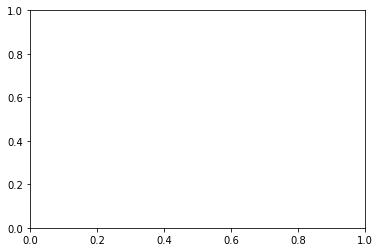

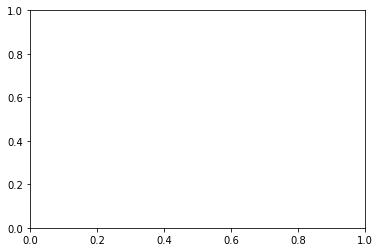

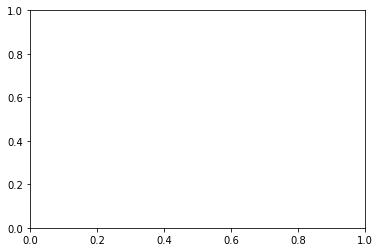

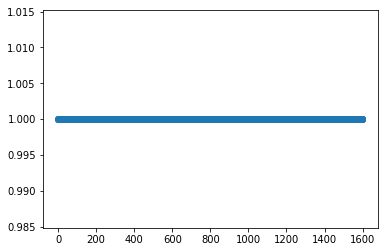

In [75]:
plt.scatter(range(start,samp),det_collection)
plt.show()

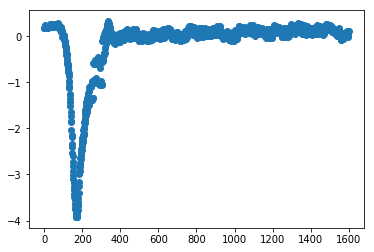

In [76]:
plt.scatter(range(start,samp),x_acc_coll)
plt.show()

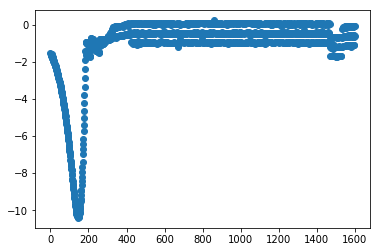

In [77]:
plt.scatter(range(start,samp),y_acc_coll)
plt.show()

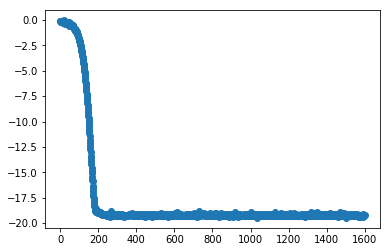

In [78]:
plt.scatter(range(start,samp),z_acc_coll)
plt.show()

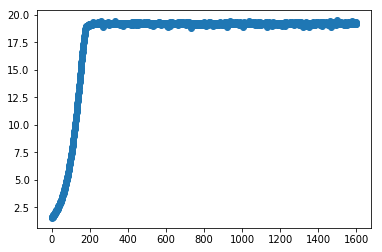

In [79]:
plt.scatter(range(start,samp),tot_acc_coll)
plt.show()

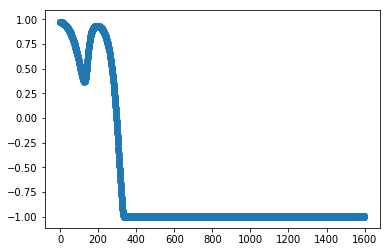

In [80]:
plt.scatter(range(start,samp),firsty)
plt.show()

In [93]:
aardvark = z_acc_coll[600:]
print(np.std(aardvark))
print(np.mean(aardvark))
thingie = np.mean(aardvark)


0.0637013875176
-19.2054194347


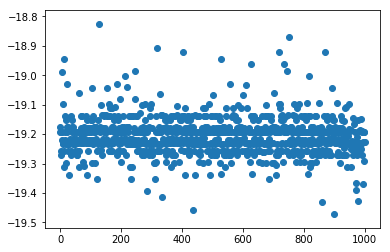

In [94]:
plt.scatter(range(start,len(aardvark)),aardvark)
plt.show()

In [95]:
for i in range(0,len(aardvark)):
    aardvark[i]=aardvark[i]-thingie

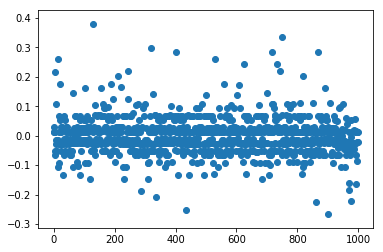

In [96]:
plt.scatter(range(start,len(aardvark)),aardvark)
plt.show()

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt